# *Lab 03: VGG*
trong bài thực hành này:

* Cài đặt, train VGG16 với data MNIST
* Các kĩ thuật regularization: L2 (weight decay), dropout
* Tạo callback của keras để lưu checkpoint

**Reference**: Simonyan, K., and Zisserman, A. 2014b. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556. https://arxiv.org/abs/1409.1556

1. Regularization là một kĩ thuật thay đổi mô hình một chút để tránh overfitting trong khi vẫn giữ tính tổng quá của nó (tính tổng quát là tính mô tả được dữ liệu, trong cả tập training và testing). Một cách cụ thể hơn, ta tìm cách di chuyển nghiệm của bài toán tối ưu hàm mất mát tới một điểm gần nó. Hướng di chuyển sẽ là hướng làm cho mô hình ít phức tạp hơn mặc dù giá trị hàm mất mát có tăng lên một chút. 

Ở đây L2 chính là thêm vào hàm mất mát một lượng λR(θ), với:
* λ là một số dương
* R(θ) là số hạng regularization 

2.  Dropout là một phương pháp tắt ngẫu nhiên các units trong Networks. Tắt tức cho các unit giá trị bằng không và tính toán feedforward và backpropagation bình thường trong khi training. Việc này không những giúp lượng tính toán giảm đi mà còn làm giảm việc overffitng.

3. Khi chạy mô hình học sâu, chúng ta nên lưu lại các checkpoints để khi có lỗ lúc huấn luyện, ta có thể huấn luyện lại tại checkpoint trước đó, mà không cần phải huấn luyện lại từ đầu




#Các biến thể của VGG

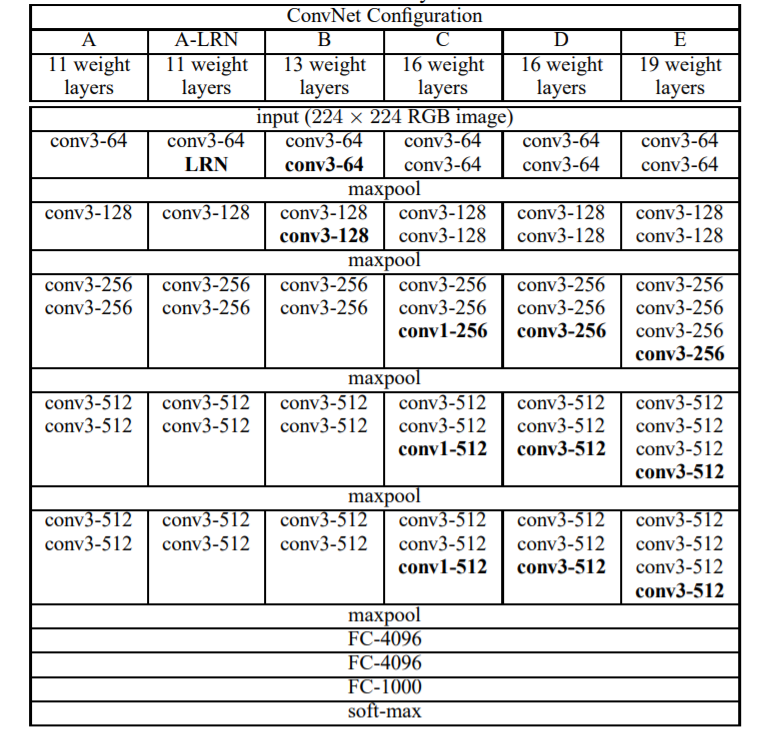

Hình trên trích từ bài báo gốc của VGG. Cột D và E chính là cấu trúc model VGG16 và VGG19.

* Filter size của tất cả các lớp convolution là 3x3
Số filter của từng block lần lượt là 64, 128, 256, 512, 512
* Các hàm kích hoạt đều là ReLU, trừ lớp output dùng hàm kích hoạt softmax
L2 Regularizer (weight decay) các lớp dense: 0.0005
* Dropout probability sau các lớp dense: 0.5


In [1]:
#import các thư viện
import keras
from keras import backend as k
import tensorflow as tf
import numpy as np
#chọn hệ số lamda
regularizer=0.0005

Chúng ta có thể gọi mạng vgg16 đã được cài đặt sẵn bằng thư viện keras.
application:
* include_top: True/False: có thêm 3 lớp fully-conndedted ở cuối model không
* weights: None/'imagenet': None: khởi tạo tham số ngẫu nhiên; 'imagenet': load 8 trọng số của model được train với imagenet
* input_tensor: truyền lớp Input vào nếu muốn
* input_shape: xác định kích thước input
* pooling: None/'max'/'avg': chế độ pooling trong các lớp pool
classes: số lớp output

In [2]:
vgg19 = keras.applications.vgg19.VGG19(include_top=True, 
                                       weights=None, 
                                       input_tensor=None, 
                                       input_shape=(32,32,1), 
                                       pooling='max',
                                       classes=10)
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Phải resize lại ảnh do vgg16 yêu cầu kích thước tối thiểu là 32x32

In [3]:
import cv2

## tải CIFAR-100 dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

## Resize toàn bộ ảnh train tập train và test
X_train = [cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY) for img in X_train]
X_test = [cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY) for img in X_test]

X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(32,32)) for img in X_test])

print("Kích thước tập sau khi resize: ", X_train.shape, X_test.shape)

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

Kích thước tập sau khi resize:  (50000, 32, 32) (10000, 32, 32)


#Cấu trúc mô hình

In [4]:
#Khởi tạo mô hình
model=keras.Sequential()

#phải reshape lại input theo đúng (?,A,B,C)
model.add(keras.layers.Reshape((32,32,1),input_shape=(32,32)))

#block1
#Gồm 2 lớp Convolution và 1 lớp maxpooling pool_size là 2x2
#filter 64, kernel_size là 3x3 và stride 1x1, có padding, activation là relu
model.add(keras.layers.Convolution2D(filters=64,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=64,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=keras.activations.relu))
model.add(keras.layers.MaxPool2D(pool_size=[2,2],
                                 strides=[2,2]))

#block2
#Gồm 2 lớp Convolution và 1 lớp maxpooling với pool_size là 2x2
#filter 128, kernel_size là 3x3 và stride 1x1, có padding, activation là relu
model.add(keras.layers.Convolution2D(filters=128,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=128,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.MaxPool2D(pool_size=[2,2],
                    strides=[2,2]))

#block3
#Gồm 3 lớp Convolution và 1 lớp maxpooling với pool_size là 2x2
#filter 256, kernel_size là 3x3 và stride 1x1, có padding, activation là relu
model.add(keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.MaxPool2D(pool_size=[2,2],
                          strides=[2,2]))
#block4
#Gồm 3 lớp Convolution và 1 lớp maxpooling với pool_size là 2x2
#filter 512, kernel_size là 3x3 và stride 1x1, có padding, activation là relu
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.MaxPool2D(pool_size=[2,2],
                                 strides=[2,2]))
#block5
#Gồm 4 lớp Convolution và 1 lớp maxpooling với pool_size là 2x2
#filter 512, kernel_size là 3x3 và stride 1x1, có padding, activation là relu
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding="same",
                                     activation=keras.activations.relu))
model.add(keras.layers.MaxPool2D(pool_size=[2,2],
                                 strides=[2,2]))

#block 6
#Gồm lớp Flatten để duỗi ra
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=4096,
                             activation=keras.activations.relu,
                             kernel_regularizer=keras.regularizers.l2(regularizer)))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(units=4096,
                             activation=keras.activations.relu,
                             kernel_regularizer=keras.regularizers.l2(regularizer)))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(units=10,
                             activation=keras.activations.softmax))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    ##tự khai báo Optimizer với learning rate 10^-4
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [5]:
### Tạo một callback ModelCheckpoint: callback này sẽ lưu model mỗi khi tìm được một model tốt hơn
#### filepath: đường dẫn file muốn lưu
#### monitor: đại lượng quyết định xem model có "tốt hơn" hay không
#### mode='auto'/'max'/'min': đại lượng monitor lớn hay nhỏ là tốt hơn
#### verbose: có thông báo mỗi lần lưu ko
#### save_best_only: chỉ lưu model tốt nhất
mc = keras.callbacks.ModelCheckpoint(filepath="vgg16_mnist.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)

## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=124,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])                     ##sử dụng callback ModelCheckpoint trong quá trình train


## Đánh giá model trên tập test
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

## Load lại model tốt nhất đã lưu
print("best model: ")
model.load_weights("vgg16_mnist.h5")
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} acc {}".format(valid_loss, valid_acc, test_loss, test_acc))

Epoch 1/10
323/323 [==============================] - 14s 44ms/step - loss: 2.9432 - accuracy: 0.1657 - val_loss: 2.1638 - val_accuracy: 0.2426
Epoch 2/10
323/323 [==============================] - 14s 42ms/step - loss: 1.9394 - accuracy: 0.2978 - val_loss: 1.8226 - val_accuracy: 0.3366
Epoch 3/10
323/323 [==============================] - 14s 43ms/step - loss: 1.6842 - accuracy: 0.3951 - val_loss: 1.6115 - val_accuracy: 0.4289
Epoch 4/10
323/323 [==============================] - 14s 42ms/step - loss: 1.4970 - accuracy: 0.4760 - val_loss: 1.3785 - val_accuracy: 0.5266
Epoch 5/10
323/323 [==============================] - 14s 42ms/step - loss: 1.2983 - accuracy: 0.5559 - val_loss: 1.2707 - val_accuracy: 0.5719
Epoch 6/10
323/323 [==============================] - 14s 42ms/step - loss: 1.1371 - accuracy: 0.6196 - val_loss: 1.1142 - val_accuracy: 0.6303
Epoch 7/10
323/323 [==============================] - 14s 42ms/step - loss: 0.9919 - accuracy: 0.6694 - val_loss: 0.9928 - val_accuracy:

# Bài Tập
1. Hãy dùng thư viện keras.layers để cài đặt VGG19 huấn luyện trên bộ dữ liệu cifar-10
2. Chỉnh các tham số (lrn_rate, l2 weight decay, epochs, batch_size) và nhận xét performance sẽ thay đổi như thế nào 


In [6]:


## tải CIFAR-100 dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

import cv2
## Resize toàn bộ ảnh train tập train và test
X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(32,32)) for img in X_test])
print("Kích thước tập sau khi resize: ", X_train.shape, X_test.shape)

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

Kích thước tập sau khi resize:  (50000, 32, 32, 3) (10000, 32, 32, 3)
